# OPTRAM

In [136]:
import pandas as pd
import utm 
import folium
import re
from pathlib import Path
import geopandas as gpd
from shapely import geometry
from osgeo import gdal
import rasterio
import numpy as np
import numpy.ma as ma
from rasterio import plot
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import datetime
#from datetime import datetime, timedelta

import rasterio as rs
from scipy import stats
import sys
import glob
import haversine as hs
from haversine import Unit
from shapely.geometry import Point
from os import listdir
from os.path import isfile, join

### Functions

In [182]:
def utm_to_latlon(coords, zone_number, zone_letter):
    easting = coords[0]
    northing = coords[1]
    return utm.to_latlon(easting, northing, zone_number, zone_letter)


def S2_getDate(filename) :
    basename = Path(filename).stem  
    try :
        found = re.search('S2(A|B)2A_(\d+)_.*',basename).group(2)
        dt = datetime.datetime.strptime(found, '%Y%m%d')
        
    except AttributeError:
        raise ValueError('Error: Date can not be extracted from filename %s .' % filename)
        
    return dt


def S2_getSCL(BASE_DIR, date) :
    
    if (isinstance(date, datetime.date)) : 
        date_str = date.strftime("%Y%m%d")
    
    elif (isinstance(date, str)):
        print('"str" type object detected, converting to datetime.')
        date_obj = datetime.datetime.strptime(date, "%Y%m%d") 
        date_str = date_obj.strftime("%Y%m%d")
        
    else : 
        raise TypeError('Error:  %s encountered, but "str" o "datetime.date" expected' % type(date))
    
    pattern = BASE_DIR + 'SCL/' + '*' + date_str + '*'
    
    try: 
        filepath = glob.glob(pathname = pattern)
        return filepath[0]
    
    except AttributeError: 
        print('Error: File with pattern %s not found' % pattern)

        
def S2_get_sensing_dt(boa_fp):
    days_offset = 1
    start_dt = S2_getDate(boa_fp) - datetime.timedelta(days=days_offset)
    end_dt   = S2_getDate(boa_fp) + datetime.timedelta(days=days_offset)
    
    start_dt = start_dt.strftime('%Y-%m-%d')
    end_dt   = end_dt.strftime('%Y-%m-%d')

    now = datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")
    print('%s : Requesting image metadata between %s <-> %s...' % (now, start_dt, end_dt))
    # bash callback: 
    dts = ! Rscript ./sen2r/sat_sensing_dt.R $start_dt $end_dt ./sen2r/Walnut-Gulch.geojson 2> /dev/null
    print('%s : Done\n' % datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

    sensing_datetime = datetime.datetime.strptime(dts[1], '                                        "%Y-%m-%d %H:%M:%S UTC" ')
    return sensing_datetime


def is_defective_px(SCL_px_val):
    
    if ((SCL_px_val == 4) | (SCL_px_val == 5)): # vegetated OR not_vegetated
        return False
    
    else : 
        return True

# Vectorized version
is_defective_px_vect = np.vectorize(is_defective_px)

# TODO: maybe in the denominator are included alpha values and thus
# computing an undervaluated percentage ?
# TODO type checks 
# TODO shape checks  
def S2_defective_px_perc(scl_raster) : 
    not_defective = sum(~np.array(is_defective_px_vect(scl_raster)))
    perc = not_defective / len(np.ndarray.flatten(scl_raster))
    return perc

def get_px_coords_from_raster(boa) :
    dataset = boa
    val = boa.read(3, masked = True)
    no_data = dataset.nodata
    geometry = [Point(dataset.xy(x,y)[0],dataset.xy(x,y)[1]) for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
    coords_utm = [(point.x, point.y)  for point in geometry]
    return (zip(*coords_utm))

def build_inSitu_obs(df, dest_lat_lng, sensor_df, utm_n = 12, utm_z = 'N') :
    
    # Calculate the closest image pixel to the sensor
    x = df.loc[:,'utm_x'].tolist()
    y = df.loc[:,'utm_y'].tolist()
    
    print('%s : Calculating haversine distance for %d rows...'
          % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"), len(df)))
    
    dists = [  hs.haversine(utm_to_latlon(item, utm_n, utm_Z),
                            dest_lat_lng, unit = Unit.METERS)
        
               for item in zip(x,y) 
    ]
    print('%s : Done\n' % datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

    df['dist'] = dists
    
    print('%s : Sorting %d rows...' % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"), len(df)))
    df.sort_values('dist', inplace = True)
    print('%s : Done\n' % datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

    df = df.head(1)
    df.set_index('datetime', inplace = True)
    
    # Get the corresponding sensor obs to the pixel
    
    #https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date
    def nearest(items, pivot):
        return min(items, key=lambda x: abs(x - pivot))
              
    nearest_dt = nearest(items = sensor_df.index, pivot = df.index[0])
    val = sensor_df.loc[sensor_df.index == nearest_dt, 'SM5'].values
    print('nearest_dt: %s, %s'% (nearest_dt, val))
    df['SM5'] = val
    return df

In [13]:
if False: # Do not run
    
    fname = "./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulch_BOA_10.tif"
    print(S2_getDate(fname))
    
    SCL_file = S2_getSCL(BASE_DIR, date = '20181213')  
    print(SCL_file)
    

## REGION OF STUDY


In [14]:
swrc = gpd.read_file('./WG-boundary/boundary/boundary.shp')
swrc

,MAJOR_SUBW,Shape_Leng,Shape_Area,geometry
0,1.0,78272.01636,1.477542e+08,"POLYGON ((605817.380 3515703.128, 605817.505 3..."


Plotting with Folium requires lat, long data, so we have to convert from UTM

In [15]:
# Arizona
utm_N = 12 
utm_Z = 'N'

x,y = swrc.geometry[0].exterior.coords.xy
points = []
for i in range(len(swrc.geometry[0].exterior.coords.xy[1])) : 
    points.append(utm_to_latlon(coords = [x[i], y[i]],
                                zone_number = utm_N,
                                zone_letter = utm_Z))
 

points_rev = [(y,x) for x,y in points]
swrc['geometry'] = geometry.Polygon(points_rev)

Also we want to plot the locations of ground probes: 

In [16]:
# https://www.tucson.ars.ag.gov/dap/dap_docs/soil.html
TDRL1_utm = [589567, 3512290] 
TDRL2_utm = [589793, 3512420]
RG28_utm  = [590624, 3509990]

TDRL1_latlong = utm_to_latlon(coords = TDRL1_utm, 
                              zone_number = utm_N,
                              zone_letter = utm_Z)

TDRL2_latlong = utm_to_latlon(coords = TDRL2_utm, 
                              zone_number = utm_N,
                              zone_letter = utm_Z)

RG28_latlong = utm_to_latlon(coords = RG28_utm, 
                             zone_number = utm_N,
                             zone_letter = utm_Z)

sensors_coords = dict({
    'TDRL1' : TDRL1_latlong,
    'TDRL2' : TDRL2_latlong,
    'RG28'  : RG28_latlong  
})

In [17]:
m = folium.Map(location = [31.713068,  -110.025442],
               zoom_start = 11,
               tiles = "CartoDB positron")

for _, r in swrc.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    geo_j.add_to(m)
    

folium.Marker(TDRL1_latlong, popup="TDRL1").add_to(m)
m.add_child(folium.ClickForMarker(popup="Waypoint"))

folium.Marker(TDRL2_latlong, popup="TDRL2").add_to(m)
m.add_child(folium.ClickForMarker(popup="Waypoint"))

folium.Marker(RG28_latlong, popup="RG28").add_to(m)
m.add_child(folium.ClickForMarker(popup="Waypoint"))

m

 Shapefile to geojson conversion

In [18]:
swrc.to_crs(epsg=4326)
swrc.to_file('./sen2r/Walnut-Gulch.geojson', driver='GeoJSON')

/home/vyago/miniconda3/envs/spatial/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## LOAD DATA

### Sensor 

In [116]:
names = ["site", "year", "day", "hr", "mn", "SM5", "SM15", "SM30", "SM50", "SM75", "SM100", "SM200"]
l1tdr18 = pd.read_csv('https://www.tucson.ars.ag.gov/metDAP/SoilProfileSiteData/l1tdr18.out',
                  sep='\s+', 
                  names = names)

l2tdr18 = pd.read_csv('https://www.tucson.ars.ag.gov/metDAP/SoilProfileSiteData/l2tdr18.out',
                  sep='\s+', 
                  names = names)

names = ["site", "year", "day", "hr", "mn", "SM5", "ST5"]
rg28    = pd.read_csv('https://www.tucson.ars.ag.gov/metDAP/RaingageSiteData/rg28vt18.out',
                  sep=',', 
                  names = names)

In [117]:
l1tdr18["datetime"] = (
                        pd.to_datetime(l1tdr18['year'] * 1000 + l1tdr18['day'], format='%Y%j') 
                        +
                        pd.to_timedelta(l1tdr18["hr"], unit="h") 
                        +
                        pd.to_timedelta(l1tdr18["mn"], unit="min") 
                      )

l2tdr18["datetime"] = (
                        pd.to_datetime(l2tdr18['year'] * 1000 + l2tdr18['day'], format='%Y%j') 
                        +
                        pd.to_timedelta(l2tdr18["hr"], unit="h") 
                        +
                        pd.to_timedelta(l2tdr18["mn"], unit="min") 
                      )

rg28["datetime"]    = (
                        pd.to_datetime(rg28['year'] * 1000 + rg28['day'], format='%Y%j') 
                        +
                        pd.to_timedelta(rg28["hr"], unit="h") 
                        +
                        pd.to_timedelta(rg28["mn"], unit="min") 
                      )

In [118]:
l1tdr18.set_index('datetime', inplace = True)
l2tdr18.set_index('datetime', inplace = True)
rg28.set_index('datetime', inplace = True)

Its obvious **6999** represent a _no_data_ value.

In [119]:
l1tdr18_fix = l1tdr18.replace(6999, None)
l2tdr18_fix = l2tdr18.replace(6999, None)
rg28_fix    = rg28.replace(6999, None)

In [ ]:
#fig, (ax1, ax2) = plt.subplots(2, figsize = (10,3), sharex= True)
#fig.suptitle('l1tdr18 - SM 5 cm')
#ax1.plot(l1tdr18.loc[:,'SM5'].index, l1tdr18.loc[:,'SM5'])
#ax2.plot(l2tdr18.loc[:,'SM5'].index, l2tdr18.loc[:,'SM5'])

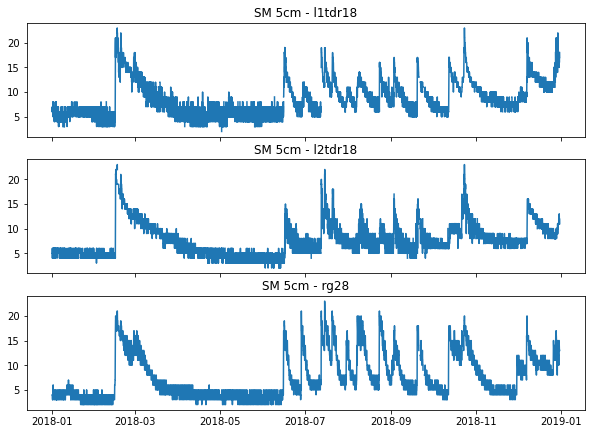

In [120]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (10,5), sharex= True)
ax1.plot(l1tdr18_fix.loc[:,'SM5'].index, l1tdr18_fix.loc[:,'SM5'])
ax2.plot(l2tdr18_fix.loc[:,'SM5'].index, l2tdr18_fix.loc[:,'SM5'])
ax3.plot(rg28_fix.loc[:,'SM5'].index, rg28_fix.loc[:,'SM5'])

ax1.title.set_text('SM 5cm - l1tdr18')
ax2.title.set_text('SM 5cm - l2tdr18')
ax3.title.set_text('SM 5cm - rg28')

#https://stackoverflow.com/questions/6541123/improve-subplot-size-spacing-with-many-subplots-in-matplotlib
plt.subplots_adjust(left=None, bottom=None, right=None, top=1.2 , wspace=None, hspace=None)


In [130]:
sensors_df = dict({
    'TDRL1' : l1tdr18_fix.sort_index(),
    'TDRL2': l2tdr18_fix.sort_index(), 
    'RG28': rg28_fix.sort_index()
})

# TODO : assert sensors_coords & sensors_dict have the same keys

### Satellite

In [185]:
BASE_DIR = './sen2r/out/'
BASE_DIR_BOA = './sen2r/out/BOA_2/'

boa_files = [f for f in listdir(BASE_DIR_BOA,) if isfile(join(BASE_DIR_BOA, f))]
local_df_list = []
inSitu_obs_dict = { key:[] for key, value in sensors_coords.items()}

for file in boa_files : 
    
    print('%s : processing file %s... \n' % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"), file))
    
    boa_fp = BASE_DIR_BOA + file

    raster_date = S2_getDate(boa_fp)
    scl_fp = S2_getSCL(BASE_DIR, raster_date)
    
    boa  = rs.open(boa_fp)
    scl  = rs.open(scl_fp)
    r    = boa.read(3, masked = True)
    nir  = boa.read(8, masked = True)
    swir = boa.read(11, masked = True)
    swir = swir / 10000 #  #SWIR2 band 12 http://sen2r.ranghetti.info/articles/outstructure.html
    ndvi = (nir - r)/(nir + r)
    STR  = ((1-swir)**2)/(2*swir)
    scl  = scl.read(1, masked = True)

    print('%s : retrieving px coords...' % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
    utm_x, utm_y =  get_px_coords_from_raster(boa)
    print('%s : Done\n' % datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"))
   
    # TODO : check nubosity perc before proccess the following
    
    data = {
        'datetime' : S2_get_sensing_dt(boa_fp),
        'ndvi' : np.ndarray.flatten(ndvi[~ndvi.mask]),
        'str'  : np.ndarray.flatten(STR[~STR.mask]),
        'defective_px_perc' : S2_defective_px_perc(np.ndarray.flatten(scl.data)),
        'utm_x' : utm_x, 
        'utm_y' : utm_y,
        'fpath' : boa_fp
    }
    
    local_df = pd.DataFrame(data)
    local_df.drop(local_df[local_df.loc[:,"ndvi"] > 1].index, inplace=True)
    local_df_list.append(local_df)
    
    # TODO: cpu intesive due to sorting 'sensor.items()' times a df w/ 4M+ rows
    # Speedup: pre-calcualte the sortest px to each sensor before outer loop, then just query the NDVI,STR value at index
    for sensor_name, sensor_coords in sensors_coords.items() :
        inSitu_obs = build_inSitu_obs(df = local_df,
                                      dest_lat_lng  = sensor_coords,
                                      sensor_df  = sensors_df[sensor_name])
        inSitu_obs_dict[sensor_name].append(inSitu_obs)
        

global_df = pd.concat(local_df_list) # calculate edges w/ this
inSitu_df = pd.concat([pd.concat(values) for key,values in inSitu_obs_dict.items()])

2022/03/20 21:43:42 : processing file S2B2A_20181231_041_Walnut-Gulch_BOA_10.tif... 

2022/03/20 21:43:42 : retrieving px coords...
2022/03/20 21:45:07 : Done

2022/03/20 21:45:07 : Requesting image metadata between 2018-12-30 <-> 2019-01-01...
2022/03/20 21:45:18 : Done

2022/03/20 21:45:20 : Calculating haversine distance for 1477128 rows...
2022/03/20 21:46:34 : Done

2022/03/20 21:46:34 : Sorting 1477128 rows...
2022/03/20 21:46:34 : Done

nearest_dt: 2019-01-01 00:00:00, [None]


/tmp/ipykernel_5735/3035235995.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SM5'] = val


2022/03/20 21:46:35 : Calculating haversine distance for 1477128 rows...
2022/03/20 21:47:48 : Done

2022/03/20 21:47:48 : Sorting 1477128 rows...
2022/03/20 21:47:48 : Done

nearest_dt: 2019-01-01 00:00:00, [None]
2022/03/20 21:47:49 : Calculating haversine distance for 1477128 rows...


/tmp/ipykernel_5735/3035235995.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SM5'] = val


2022/03/20 21:49:03 : Done

2022/03/20 21:49:03 : Sorting 1477128 rows...
2022/03/20 21:49:03 : Done

nearest_dt: 2018-12-31 18:00:00, [None]
2022/03/20 21:49:03 : processing file S2A2A_20181216_041_Walnut-Gulch_BOA_10.tif... 



/tmp/ipykernel_5735/3035235995.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SM5'] = val


2022/03/20 21:49:04 : retrieving px coords...
2022/03/20 21:50:28 : Done

2022/03/20 21:50:28 : Requesting image metadata between 2018-12-15 <-> 2018-12-17...
2022/03/20 21:50:38 : Done

2022/03/20 21:50:40 : Calculating haversine distance for 378993 rows...
2022/03/20 21:50:59 : Done

2022/03/20 21:50:59 : Sorting 378993 rows...
2022/03/20 21:50:59 : Done

nearest_dt: 2018-12-16 18:00:00, [12]
2022/03/20 21:50:59 : Calculating haversine distance for 378993 rows...


/tmp/ipykernel_5735/3035235995.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SM5'] = val


2022/03/20 21:51:19 : Done

2022/03/20 21:51:19 : Sorting 378993 rows...
2022/03/20 21:51:19 : Done

nearest_dt: 2018-12-16 18:00:00, [11]
2022/03/20 21:51:19 : Calculating haversine distance for 378993 rows...


/tmp/ipykernel_5735/3035235995.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SM5'] = val


2022/03/20 21:51:39 : Done

2022/03/20 21:51:39 : Sorting 378993 rows...
2022/03/20 21:51:39 : Done

nearest_dt: 2018-12-16 18:00:00, [11]
2022/03/20 21:51:39 : processing file S2B2A_20181221_041_Walnut-Gulch_BOA_10.tif... 



/tmp/ipykernel_5735/3035235995.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SM5'] = val


2022/03/20 21:51:39 : retrieving px coords...
2022/03/20 21:53:04 : Done

2022/03/20 21:53:04 : Requesting image metadata between 2018-12-20 <-> 2018-12-22...
2022/03/20 21:53:12 : Done

2022/03/20 21:53:14 : Calculating haversine distance for 1262658 rows...
2022/03/20 21:54:18 : Done

2022/03/20 21:54:18 : Sorting 1262658 rows...
2022/03/20 21:54:18 : Done

nearest_dt: 2018-12-21 18:00:00, [12]
2022/03/20 21:54:19 : Calculating haversine distance for 1262658 rows...


/tmp/ipykernel_5735/3035235995.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SM5'] = val


2022/03/20 21:55:25 : Done

2022/03/20 21:55:25 : Sorting 1262658 rows...
2022/03/20 21:55:25 : Done

nearest_dt: 2018-12-21 18:00:00, [10]
2022/03/20 21:55:25 : Calculating haversine distance for 1262658 rows...


/tmp/ipykernel_5735/3035235995.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SM5'] = val


2022/03/20 21:56:29 : Done

2022/03/20 21:56:29 : Sorting 1262658 rows...
2022/03/20 21:56:29 : Done

nearest_dt: 2018-12-21 18:00:00, [10]
2022/03/20 21:56:29 : processing file S2A2A_20181226_041_Walnut-Gulch_BOA_10.tif... 



/tmp/ipykernel_5735/3035235995.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SM5'] = val


2022/03/20 21:56:30 : retrieving px coords...
2022/03/20 21:57:56 : Done

2022/03/20 21:57:56 : Requesting image metadata between 2018-12-25 <-> 2018-12-27...
2022/03/20 21:58:05 : Done

2022/03/20 21:58:07 : Calculating haversine distance for 1242912 rows...
2022/03/20 21:59:11 : Done

2022/03/20 21:59:11 : Sorting 1242912 rows...
2022/03/20 21:59:11 : Done

nearest_dt: 2018-12-26 18:00:00, [12]


/tmp/ipykernel_5735/3035235995.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SM5'] = val


2022/03/20 21:59:11 : Calculating haversine distance for 1242912 rows...
2022/03/20 22:00:14 : Done

2022/03/20 22:00:14 : Sorting 1242912 rows...
2022/03/20 22:00:15 : Done

nearest_dt: 2018-12-26 18:00:00, [9]
2022/03/20 22:00:15 : Calculating haversine distance for 1242912 rows...


/tmp/ipykernel_5735/3035235995.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SM5'] = val


2022/03/20 22:01:19 : Done

2022/03/20 22:01:19 : Sorting 1242912 rows...
2022/03/20 22:01:19 : Done

nearest_dt: 2018-12-26 18:00:00, [14]


/tmp/ipykernel_5735/3035235995.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SM5'] = val


In [152]:
global_df

,datetime,ndvi,str,defective_px_perc,utm_x,utm_y,fpath,dist
815140,2018-12-21 18:07:49,0.000693,0.724695,0.0,590625.0,3509995.0,./sen2r/out/BOA_2/S2B2A_20181221_041_Walnut-Gu...,5.113909
817136,2018-12-21 18:07:49,0.005196,0.719876,0.0,590615.0,3509985.0,./sen2r/out/BOA_2/S2B2A_20181221_041_Walnut-Gu...,10.289143
815141,2018-12-21 18:07:49,0.000695,0.724695,0.0,590635.0,3509995.0,./sen2r/out/BOA_2/S2B2A_20181221_041_Walnut-Gu...,12.071676
819132,2018-12-21 18:07:49,0.000348,0.716828,0.0,590625.0,3509975.0,./sen2r/out/BOA_2/S2B2A_20181221_041_Walnut-Gu...,15.080011
819131,2018-12-21 18:07:49,0.005917,0.704358,0.0,590615.0,3509975.0,./sen2r/out/BOA_2/S2B2A_20181221_041_Walnut-Gu...,17.524335
...,...,...,...,...,...,...,...,...
9323,2018-12-21 18:07:49,0.051861,1.639050,0.0,606215.0,3515195.0,./sen2r/out/BOA_2/S2B2A_20181221_041_Walnut-Gu...,16415.481253
10398,2018-12-21 18:07:49,0.047968,1.666673,0.0,606235.0,3515145.0,./sen2r/out/BOA_2/S2B2A_20181221_041_Walnut-Gu...,16418.549471
9766,2018-12-21 18:07:49,0.051793,1.656554,0.0,606225.0,3515175.0,./sen2r/out/BOA_2/S2B2A_20181221_041_Walnut-Gu...,16418.580902
10194,2018-12-21 18:07:49,0.041526,1.666673,0.0,606235.0,3515155.0,./sen2r/out/BOA_2/S2B2A_20181221_041_Walnut-Gu...,16421.710546


In [186]:
inSitu_df

,ndvi,str,defective_px_perc,utm_x,utm_y,fpath,dist,SM5
datetime,,,,,,,,
2018-12-31 18:07:39,0.353846,1.147791,0.448279,589565.0,3512285.0,./sen2r/out/BOA_2/S2B2A_20181231_041_Walnut-Gu...,5.398217,None
2018-12-16 18:07:41,0.035757,3.633355,0.000311,589565.0,3512285.0,./sen2r/out/BOA_2/S2A2A_20181216_041_Walnut-Gu...,5.398217,12
2018-12-21 18:07:49,0.001087,0.732662,0.000000,589565.0,3512285.0,./sen2r/out/BOA_2/S2B2A_20181221_041_Walnut-Gu...,5.398217,12
2018-12-26 18:07:41,0.038696,0.638298,0.055532,589565.0,3512285.0,./sen2r/out/BOA_2/S2A2A_20181226_041_Walnut-Gu...,5.398217,12
2018-12-31 18:07:39,0.289164,1.367118,0.448279,589795.0,3512425.0,./sen2r/out/BOA_2/S2B2A_20181231_041_Walnut-Gu...,5.398212,None
2018-12-16 18:07:41,0.026076,3.165990,0.000311,589795.0,3512425.0,./sen2r/out/BOA_2/S2A2A_20181216_041_Walnut-Gu...,5.398212,11
2018-12-21 18:07:49,0.003213,0.750730,0.000000,589795.0,3512415.0,./sen2r/out/BOA_2/S2B2A_20181221_041_Walnut-Gu...,5.398527,10
2018-12-26 18:07:41,0.065718,1.474096,0.055532,589795.0,3512425.0,./sen2r/out/BOA_2/S2A2A_20181226_041_Walnut-Gu...,5.398212,9
2018-12-31 18:07:39,0.232482,1.745413,0.448279,590625.0,3509995.0,./sen2r/out/BOA_2/S2B2A_20181231_041_Walnut-Gu...,5.113909,None


In [ ]:
print(sensors_df['TDRL1'].loc['2018-12-21 18:00:00','SM5'])
print(sensors_df['TDRL2'].loc['2018-12-21 18:00:00','SM5'])
print(sensors_df['RG28'].loc['2018-12-21 18:00:00','SM5'])

In [178]:
sensors_df['TDRL1'].loc[sensors_df['TDRL1'].index == '2018-12-21 18:00:00', 'SM5'].values

array([12], dtype=object)

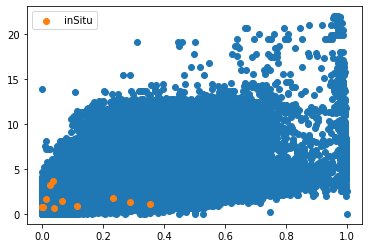

In [187]:
# TODO contour plot lines needed for clarity
plt.scatter(global_df.loc[:,'ndvi'], global_df.loc[:,'str'])
plt.scatter(inSitu_df.loc[:,'ndvi'], inSitu_df.loc[:,'str'], label = 'inSitu')
plt.legend()
plt.show()

In [119]:
global_df.describe()

,ndvi,str,defective_px_perc,utm_x,utm_y,dist
count,1.856121e+06,1.856121e+06,1.856121e+06,1.856121e+06,1.856121e+06,1.856121e+06
mean,2.770703e-01,1.591099e+00,3.568100e-01,5.923085e+05,3.509764e+06,5.674429e+03
std,1.369398e-01,6.136650e-01,1.805782e-01,5.506090e+03,2.636512e+03,2.808037e+03
min,0.000000e+00,4.898551e-03,3.107913e-04,5.801950e+05,3.503595e+06,5.113909e+00
25%,2.585139e-01,1.307895e+00,4.482785e-01,5.881250e+05,3.507785e+06,3.670045e+03
50%,3.166477e-01,1.549531e+00,4.482785e-01,5.925850e+05,3.509975e+06,5.351019e+03
75%,3.608247e-01,1.806541e+00,4.482785e-01,5.961850e+05,3.511825e+06,7.305560e+03
max,9.982502e-01,2.194668e+01,4.482785e-01,6.062350e+05,3.515705e+06,1.642488e+04


In [107]:
inSitu_df

,datetime,ndvi,str,defective_px_perc,utm_x,utm_y,fpath,dist
330677,2018-12-16 18:07:41,0.035757,3.633355,0.000311,589565.0,3512285.0,./sen2r/out/BOA_2/S2A2A_20181216_041_Walnut-Gu...,5.398217
330677,2018-12-16 18:07:41,0.035757,3.633355,0.000311,589565.0,3512285.0,./sen2r/out/BOA_2/S2A2A_20181216_041_Walnut-Gu...,5.398217
301677,2018-12-16 18:07:41,0.026076,3.165990,0.000311,589795.0,3512425.0,./sen2r/out/BOA_2/S2A2A_20181216_041_Walnut-Gu...,5.398212
301677,2018-12-16 18:07:41,0.026076,3.165990,0.000311,589795.0,3512425.0,./sen2r/out/BOA_2/S2A2A_20181216_041_Walnut-Gu...,5.398212
815140,2018-12-16 18:07:41,0.012424,1.701474,0.000311,590625.0,3509995.0,./sen2r/out/BOA_2/S2A2A_20181216_041_Walnut-Gu...,5.113909
815140,2018-12-16 18:07:41,0.012424,1.701474,0.000311,590625.0,3509995.0,./sen2r/out/BOA_2/S2A2A_20181216_041_Walnut-Gu...,5.113909


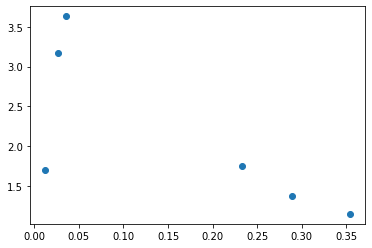

In [120]:
plt.scatter(inSitu_df.loc[:,'ndvi'], inSitu_df.loc[:,'str'])

# BASURA

In [ ]:
type(boa)

In [ ]:
py, px = boa.index(RG28_latlong[0], RG28_latlong[1]) # px coordinaes

print(px, py)

In [ ]:
print(boa.indexes)
print(boa.dtypes)

In [ ]:
boa.profile

In [ ]:
boa.lnglat() #???

In [ ]:
boa.xy

In [ ]:
fname = "./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulch_BOA_10.tif"
nir

In [ ]:
ndvi

In [ ]:
# https://gis.stackexchange.com/questions/394455/how-to-find-coordinates-of-pixels-of-a-geotiff-image-with-python
fname = "./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulch_BOA_10.tif"
from shapely.geometry import Point

dataset = boa
val = ndvi
no_data = dataset.nodata
geometry = [Point(dataset.xy(x,y)[0],dataset.xy(x,y)[1]) for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
v = [val[x,y] for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
df = gpd.GeoDataFrame({'geometry':geometry,'data':v})
df.crs = dataset.crs
geometry

In [ ]:
print(geometry[0].xy[0])

In [ ]:
boa.read(8, masked = True)

----------